In [ ]:
import os
from typing import TypedDict, Annotated, Literal, List, Any
from langchain.agents import create_agent
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain.tools import tool, ToolRuntime
from langchain_core.output_parsers import JsonOutputParser
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.stores import InMemoryStore
from langchain_groq import ChatGroq
from langchain_community.tools import DuckDuckGoSearchRun
from pydantic import BaseModel, Field

In [2]:
class RLAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    user_input: str
    steps: str
    reasoning: str
    changes: list[str]
    first_response: str
    current_response: str
    final_response: str
    jump_to: str
    content: list[Any]
    insights: str
    first_run: bool
    approved: bool
    counter: int
    max_loop: int

In [3]:
store = InMemoryStore()
user_id = '1'
namespace = (user_id, 'insights')

In [4]:
# model = ChatGoogleGenerativeAI(
#     model='gemini-2.5-flash',
#     temperature=0.2,
#     api_key=os.getenv('GOOGLE_API_KEY')
# )

model = ChatGroq(
    model='meta-llama/llama-4-maverick-17b-128e-instruct',
    temperature=0.2,
    api_key=os.getenv('GROQ_API_KEY')
)

In [5]:
tools = [DuckDuckGoSearchRun()]

In [6]:
# tool_descriptions = [tool.description for tool in tools]

In [7]:
# tool_descriptions

In [8]:
search_agent = create_agent(model=model, tools=tools, state_schema=RLAgentState)

In [9]:
class Reasoning(BaseModel):
    steps: str = Field(description='All the planned steps in order', min_length=1)
    reasoning: str = Field(description='Reasoning and thought process', min_length=1)

class Research(BaseModel):
    target_age_group: Literal['18 and below','18-45','45 and above']
    target_gender: Literal['Male','Female', 'Non-Binary', 'Everyone']
    target_persona: str = Field(description='Persona of people who might be interested in this', min_length=1)
    research_reasoning: str = Field(description='Reasoning for selecting the target demographics', min_length=1)

class Insights(BaseModel):
    insights: str = Field(description='Insights created')

In [10]:
reasoning_parser = JsonOutputParser(pydantic_object=Reasoning)
research_parser = JsonOutputParser(pydantic_object=Research)
insights_parser = JsonOutputParser(pydantic_object=Insights)

In [11]:
reasoning_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input {input}. Your job is to plan your steps and mention your reasoning/ thought process behind your planning. You have these tools: {tools},
    In your reasoning mention your indepth thought process and explanations as to why you think this is the correct approach.
    The end goal in any plan should be creating a research report.
    Do not call any tools.
    Return your response in JSON format with this structure:
    {format_instructions}
    """
)
reasoning_chain = reasoning_prompt | model.bind(response_format={'type':'json_object'}) | reasoning_parser

reasoning_with_insights_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input: {input} and insights from previous runs: {insights}. Your job is to plan your steps for tackling the query and mention your reasoning or thought process behind your planning for each step. You have these tools: {tools}.
    In your reasoning mention your indepth thought process and explanations as to why you think this is the correct approach.
    The end goal in any plan should be creating a research report.
    Do not call any tools.
    Return your response in JSON format with this structure:
    {format_instructions}
    """
)
reasoning_with_insights_chain = reasoning_with_insights_prompt | model.bind(response_format={'type':'json_object'}) | reasoning_parser

In [12]:
@tool()
def search_browser(query : str | None, runtime: ToolRuntime[None | RLAgentState]) -> Command:
    """
    This tool calls another agent who search the web to find results
    :param query: str
    :return: Command
    """
    print('\nEntering search browser tool.....')
    messages = runtime.state['messages']
    # tool_call_id = state['messages'][-1].tool_calls[-1]['id']

    res = search_agent.invoke({
        'messages': [SystemMessage(content='You are an agent who can use DuckDuckGo Search tool to find the most relevant texts based on the user queries from the web')] + messages,
    })

    print('\nSearch output ', res['messages'][-2].content)

    # res = search_agent.invoke({
    #     'messages': SystemMessage(content='You are an agent who can use search tools to fnd the most relevant texts based on the user queries from the web') + HumanMessage(content=query),
    # })

    return Command(update=
        {
            'messages': [ToolMessage(content=res['messages'][-1].content, tool_call_id=runtime.tool_call_id)]
        }
    )
@tool()
def create_research(runtime: ToolRuntime[None | RLAgentState]) -> Command:
    """
    This tool calls another agent who creates a research based on all the gathered information from tools
    :return: Command
    """
    print('\nEntering Research tool.....')
    messages = runtime.state['messages']

    system_message = SystemMessage(content=f'You are an agent that conducts research based on the provided information from web search and responds in a structured way. Provide output in Json format using following instructions {research_parser.get_format_instructions()}')

    chain = model.bind(response_format={"type": "json_object"}) | research_parser

    res = chain.invoke([system_message]+messages)
    print(res)
    out_message = f"""
    The Research conducted is as follows:
    The Target Age group is {res['target_age_group']},
    The Target Gender is {res['target_gender']},
    The Target Persona who is interested is {res['target_persona']},
    The why: {res['research_reasoning']}
    """

    if runtime.state['first_run']:

        return Command(update=
            {
                'messages' : [ToolMessage(content=out_message, tool_call_id=runtime.tool_call_id)],
                'first_run': False,
                'first_response': out_message,
                'current_response': out_message,
                'content': [res['target_age_group'],res['target_gender'],res['target_persona'], res['research_reasoning']]
            }
        )

    else:
        return Command(update=
            {
                'messages' : [ToolMessage(content=out_message, tool_call_id=runtime.tool_call_id)],
                'current_response': out_message,
                'content': [res['target_age_group'],res['target_gender'],res['target_persona'], res['research_reasoning']]
            }
        )


In [13]:
# def convert_to_google_messages(messages):
#     new_messages = []
#     for message in messages:
#         if isinstance(message, SystemMessage):
#             new_message = {
#                 'role': 'system',
#                 'content': message.content
#             }
#         elif isinstance(message, HumanMessage):
#             new_message

#         new_messages.append(new_message)

In [14]:
tool_agents = [search_browser, create_research]
# tool_agent_names = [' Tool calls another agent who search the web to find results','This tool calls another agent who creates research based on all the gathered information from tools']

def planning_reasoning_step(state: RLAgentState):
    print('\nEntering Planning Reasoning Node.......')
    if state['first_run']:
        print('Without Insights..')
        res = reasoning_chain.invoke(
            {
                'input' : state['user_input'],
                'tools' : tool_agents,
                'format_instructions': reasoning_parser.get_format_instructions()
            }
        )

        return {
            'messages' : AIMessage(content='The Plan is as follows : ' + res['steps'] + '\n\n' +
                                           'The reasoning for them is as follows : ' + res['reasoning']),
            'reasoning' : res['reasoning'],
            'steps': res['steps'],
        }

    else:
        print('With Insights..')
        res = reasoning_with_insights_chain.invoke(
            {
                'input' : state['user_input'],
                'insights': state['insights'],
                'tools' : tool_agents,
                'format_instructions': reasoning_parser.get_format_instructions()
            }
        )
        return {
            'messages' : AIMessage(content='The Plan is as follows : ' + res['steps'] + '\n\n' +
                                           'The reasoning for them is as follows : ' + res['reasoning']),
            'reasoning' : res['reasoning'],
            'steps' : res['steps'],
        }


def router(state: RLAgentState):
    print('\nEntering Router .....')

    try:
        changes = state['changes']
        print('Router with user changes called....')
        messages = state['messages'][-2:] + [HumanMessage(content=f'These changes have been asked by the User {changes}. Incorporate them and change your research')]

        # if len(messages) > 5:
        #     messages = messages[1:]

        res = model.bind_tools(tool_agents, tool_choice='auto').invoke(messages)
        try:
            print(f'\nTool called: {res.tool_calls[0]['name']}')
        except:
            print('\nNo tool called')
        return {
            'messages' : res
        }
    except:

        messages = state['messages']
        if len(messages) > 5:
            messages = messages[1:]
        # parsed_messages = convert_to_google_messages(messages)

        res = model.bind_tools(tool_agents, tool_choice='auto').invoke(messages)
        try:
            print(f'\nTool called: {res.tool_calls[0]['name']}')
        except:
            print('\nNo tool called')
        return {
            'messages' : res
        }

def which_agent(state: RLAgentState)->Literal['search_agent',END]:

    last_message = state['messages'][-1]
    if len(last_message.tool_calls)>0:
        print(f'\nWhich Agent called....: ', last_message.tool_calls[0]['name'])
        tool = last_message.tool_calls[0]['name']
        if tool == 'search_browser':
            return 'search_agent'
        elif tool == 'create_research':
            return 'research_agent'
        else:
            return END

    else:
        return END

def hitl(state: RLAgentState):

    message = state['current_response'] if 'current_response' in state else state['messages'][-1].content
    if state['approved'] or 'approved' not in state:
        print('\nEntering HITL last time.....')
        return {
            'messages' : state['messages'],
        }

    else:
        print('\nEntering HITL.......')
        output = [state['reasoning'], message, state['content'] if 'content' in state else None]
        changes = interrupt(
            output
        )

        print('Human Feedback:  ', changes)
        if changes == 'Approved':
            return {
                'messages': AIMessage(content='No changes needed. Proceed to Finalise Research'),
                'final_response': state['current_response'],
                'jump_to': 'END',
                'approved': True
            }

        else:
            return {
                'messages': AIMessage(content=f'Changes added. Refer the changes : {changes} and proceed to redo the create research step'),
                'changes': state['changes'].append(changes) if 'changes' in state else [changes],
                'jump_to': 'router',
                'approved': False
            }

def is_approved(state: RLAgentState)->Literal[END,'router']:

    if state['jump_to'] == 'END':
        return END
    else:
        return 'router'

def create_insights(state: RLAgentState):

    first_output = state['first_response'] if 'first_response' in state else state['messages'][-1]
    input = state['user_input']
    final_response = state['current_response'] if 'current_response' in state else state['messages'][-1].content
    changes = state['changes'] if 'changes' in state else ['No changes made by Human']

    prompt = f"""
    You are an agent which generates insights for long term knowledge gain based on user query, first and last agent responses and the human given changes.
    User Input : {input}
    First Response : {first_output}
    Last Response : {final_response}
    changes: {changes}
    Give Response in a JSON format using the following instructions {insights_parser.get_format_instructions()}
    """

    chain = model.bind(response_format={'type':'json_object'}) | insights_parser
    res = chain.invoke(prompt)

    return {


        'messages' : AIMessage(content=res['insights']),
        'insights' : res['insights'],
    }

search_browser_node = ToolNode(name='search_agent', tools=[search_browser])
create_research_node = ToolNode(name='research_agent', tools=[create_research])
# tool_agents_node = ToolNode(name='tool_agents', tools=tool_agents)

In [30]:
checkpointer = InMemorySaver()
config = {
    'configurable' : {
        'thread_id': '1'
    }
}

In [31]:
def test_is_tool_call(state: RLAgentState)->Literal['tool_agents', END]:

    last_message = state['messages'][-1]

    if len(last_message.tool_calls)>0:
        return 'tool_agents'
    else:
        return END

In [32]:
graph = StateGraph(RLAgentState)

graph.add_node('planning_reasoning', planning_reasoning_step)
graph.add_node('router', router)
# graph.add_node('tool_agents', tool_agents_node)
graph.add_node('search_browser', search_browser_node)
graph.add_node('create_research', create_research_node)
graph.add_node('hitl', hitl)
graph.add_node('insights', create_insights)
graph.add_edge(START, 'planning_reasoning')
graph.add_edge('planning_reasoning', 'router')
# graph.add_conditional_edges('router', test_is_tool_call)
graph.add_conditional_edges('router', which_agent, {
    'search_agent': 'search_browser',
    'research_agent':'create_research',
    END : 'hitl'
})
graph.add_edge('search_browser','router')
# graph.add_edge('create_research', 'router')
graph.add_edge('create_research', 'hitl')
# graph.add_edge('tool_agents', 'router')
# graph.add_edge('tool_agents', 'hitl')
graph.add_conditional_edges('hitl', is_approved, {
    END: 'insights',
    'router': 'router'
})
# graph.add_edge('hitl', 'insights')

agent = graph.compile(checkpointer=checkpointer)

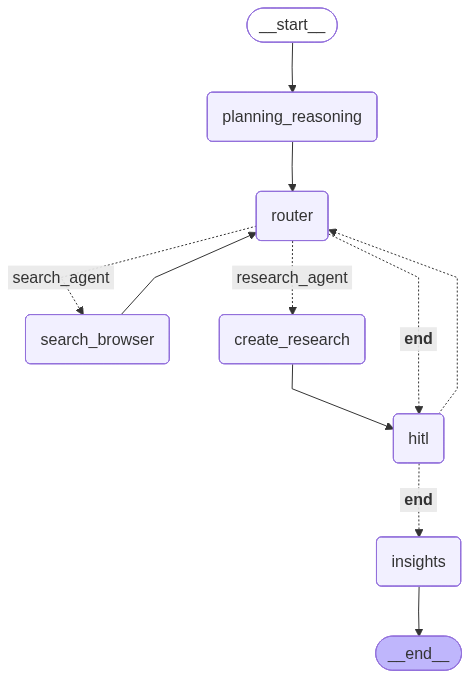

In [33]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [34]:
input_text = 'Nvidia RTX-5090 Ti'

In [35]:
insights = ''

In [36]:
res = agent.invoke(
    {
        'messages': HumanMessage(content=input_text),
        'user_input': input_text,
        'insights': insights,
        'first_run': False,
        'approved': False,
        'counter': 0,
        'max_loop': 2,
    },
    config=config
)


Entering Planning Reasoning Node.......
With Insights..

Entering Router .....

Tool called: search_browser

Which Agent called....:  search_browser

Entering search browser tool.....

Search output  However, it ’ s also possible that Nvidia will add an RTX 5090 Ti or Titan towards the end of the 5000-series product cycle — if the ... Speculative filings, but still a hint that RTX 5000 GPUs are imminent ... Nvidia Visit your regional NVIDIA website for local content, pricing ... Bring the power of NVIDIA AI to the edge for real-time decision-making solutions Powered by NVIDIA Blackwell, GeForce RTX ™ 50 Series GPUs bring game-changing capabilities to gamers and creators. Nvidia ’ s new RTX 5090 and RTX 5080 GPUs will both be available on January 30th, with the RTX 5070 Ti and RTX 5070 to follow in February.

Entering Router .....

Tool called: create_research

Which Agent called....:  create_research

Entering Research tool.....
{'target_age_group': '18-45', 'target_gender': 'Male', '

In [37]:
for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

Nvidia RTX-5090 Ti
================================== Ai Message ==================================

The Plan is as follows : 1. Understand the user input 'Nvidia RTX-5090 Ti' and identify it as a hypothetical or upcoming high-end graphics card from Nvidia, likely an advancement or variant of the RTX 5090. 2. Utilize the 'search_browser' tool to gather information on the Nvidia RTX-5090 Ti, focusing on its specifications, expected release date, and potential applications, especially in professional CAD and rendering workflows like Solidworks. 3. Analyze the gathered information to identify key features, improvements over its predecessor, and its target demographic. 4. Use the 'create_research' tool to compile the analyzed information into a comprehensive research report, highlighting the graphics card's capabilities, potential impact on the market, and relevance to both general consumers and professionals

In [38]:
res['content']

['18-45',
 'Male',
 'Tech enthusiasts and professionals in the field of graphics design, gaming, and video editing',
 "The Nvidia RTX-5090 Ti, being a high-end graphics card, is likely to appeal to tech enthusiasts and professionals who require advanced graphics processing capabilities. The age group of 18-45 is targeted as it encompasses the majority of the demographic interested in technology and computing. The gender is skewed towards male as historically, men have shown a higher interest in gaming and high-end computing hardware. However, this doesn't exclude other genders from being interested. The reasoning is based on the typical demographic for high-end graphics cards and the professional applications they serve."]

In [39]:
if res.get("__interrupt__"):
    print("Interrupted! Waiting for human input...")
    print(res["__interrupt__"])

    # Get human decision here
    user_decision = input("Enter your value: ")

Interrupted! Waiting for human input...
[Interrupt(value=["The given user input 'Nvidia RTX-5090 Ti' suggests a high-end graphics card, potentially an upgraded version or a variant of the Nvidia RTX 5090. The first step involves understanding this context. The 'search_browser' tool is essential for gathering up-to-date information on this specific model, as it is not yet known or confirmed by Nvidia. By searching for the Nvidia RTX-5090 Ti, we can uncover details about its specifications, release timeline, and how it compares to existing models, particularly in professional applications like Solidworks. After gathering sufficient information, the 'create_research' tool will be used to synthesize this data into a detailed research report. This report will outline the graphics card's features, its potential applications, and its significance for different user groups, thereby fulfilling the task's objective of creating a research report based on the given input and available insights.", 

In [40]:
res2 = agent.invoke(Command(resume=user_decision), config=config)


Entering HITL.......
Human Feedback:   Target Gender is Everyone

Entering Router .....
Router with user changes called....

Tool called: create_research

Which Agent called....:  create_research

Entering Research tool.....
{'target_age_group': '18-45', 'target_gender': 'Everyone', 'target_persona': 'Tech enthusiasts and professionals in the field of graphics design, gaming, and video editing', 'research_reasoning': "The Nvidia RTX-5090 Ti, being a high-end graphics card, is likely to appeal to tech enthusiasts and professionals who require advanced graphics processing capabilities. The age group of 18-45 is targeted as it encompasses the majority of the demographic interested in technology and computing. The target gender is considered as 'Everyone' as the interest in high-end graphics cards is not limited to a specific gender. The reasoning is based on the typical demographic for high-end graphics cards and the professional applications they serve."}

Entering HITL.......


In [41]:
for msg in res2['messages']:
    msg.pretty_print()

================================ Human Message =================================

Nvidia RTX-5090 Ti
================================== Ai Message ==================================

The Plan is as follows : 1. Understand the user input 'Nvidia RTX-5090 Ti' and identify it as a hypothetical or upcoming high-end graphics card from Nvidia, likely an advancement or variant of the RTX 5090. 2. Utilize the 'search_browser' tool to gather information on the Nvidia RTX-5090 Ti, focusing on its specifications, expected release date, and potential applications, especially in professional CAD and rendering workflows like Solidworks. 3. Analyze the gathered information to identify key features, improvements over its predecessor, and its target demographic. 4. Use the 'create_research' tool to compile the analyzed information into a comprehensive research report, highlighting the graphics card's capabilities, potential impact on the market, and relevance to both general consumers and professionals

In [43]:
res2['content']

['18-45',
 'Everyone',
 'Tech enthusiasts and professionals in the field of graphics design, gaming, and video editing',
 "The Nvidia RTX-5090 Ti, being a high-end graphics card, is likely to appeal to tech enthusiasts and professionals who require advanced graphics processing capabilities. The age group of 18-45 is targeted as it encompasses the majority of the demographic interested in technology and computing. The target gender is considered as 'Everyone' as the interest in high-end graphics cards is not limited to a specific gender. The reasoning is based on the typical demographic for high-end graphics cards and the professional applications they serve."]

In [42]:
res2['insights']

'The Nvidia RTX 5090, a high-end graphics card, targets a broad demographic including tech enthusiasts, gamers, and professionals. Beyond general demanding applications, it is also specifically relevant for users engaged in design applications such as Solidworks, indicating its utility in professional CAD and rendering workflows.'